# Uplift model metric exploration
This python notebook is for understanding the metrics of uplift models. The scenario is we are training a conversion model predicting whether users would be converted after we show them ads. In the treatment group we show users some ads and in the control group we did not. We want to have a conversion model to help us find the users who are suitable for the ads.

The goal of this notebook is understanding the metrics' meaning from sklift.

In [1]:
# We start by creating two sets of users representing treatment group users and control group users
import pandas as pd
user_num = 1000

treatment_df = pd.DataFrame(data={'user_number': [x for x in range(user_num)]})
control_df = pd.DataFrame(data={'user_number': [x for x in range(user_num, user_num+user_num)]})
treatment_df

,user_number
0,0
1,1
2,2
3,3
4,4
...,...
995,995
996,996
997,997
998,998


In [17]:
# Now we need to determine whether the users in treatment group would be converted after we show them ads.
# The true function is if users' user_number % 10 == 0 the users would be converted.
# With this setup, we would have 10% of users be converted.
converted_parameter = 10

treatment_df['converted'] = (treatment_df['user_number']  % converted_parameter ) == 0
treatment_df['converted'] = treatment_df['converted'].astype('int32')
treatment_df['converted'].sum()

100

In [18]:
# Now let's assign converted labels to control group users. We randomly assign 5% of users being converted.
import random
random.seed(123)

label = []
for un in list(control_df['user_number']):
    if un % converted_parameter == 0 and random.random() <= 0.5:
        label.append(True)
    else:
        label.append(False)

control_df['converted'] = label
control_df['converted'] = control_df['converted'].astype('int32')
control_df['converted'].sum()

61

In [20]:
# We have converted labels now. Let's get the uplift score from models and assign group labels.
noise = 1

uplift_score = list((treatment_df['user_number']) % converted_parameter)
uplift_score = [-1 * abs((random.random() - 0.5) * noise + x) for x in uplift_score]
treatment_df['uplift_score'] = uplift_score

# Control uplift score will also affect results
uplift_score = list((control_df['user_number']) % converted_parameter)
uplift_score = [(-1 * abs((random.random() - 0.5) * noise + x)) for x in uplift_score]
control_df['uplift_score'] = uplift_score

treatment_df['treatment'] = 1
control_df['treatment'] = 0
df = pd.concat([treatment_df, control_df])
df

,user_number,converted,uplift_score,treatment
0,0,1,-0.036540,1
1,1,0,-0.949676,1
2,2,0,-2.438193,1
3,3,0,-2.623992,1
4,4,0,-3.903855,1
...,...,...,...,...
995,1995,0,-4.990387,0
996,1996,0,-5.505119,0
997,1997,0,-7.145062,0
998,1998,0,-7.561787,0


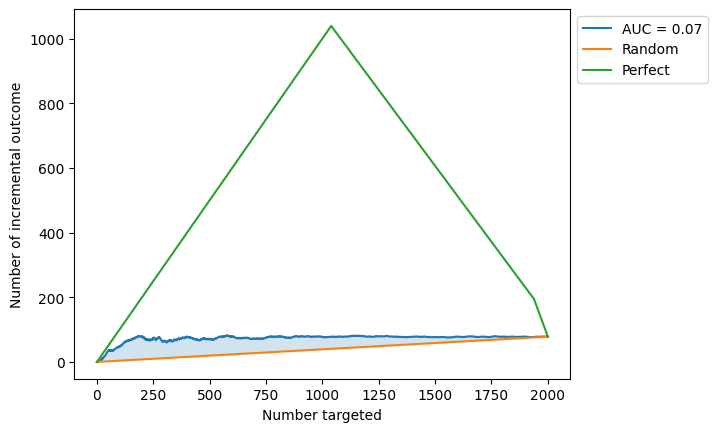

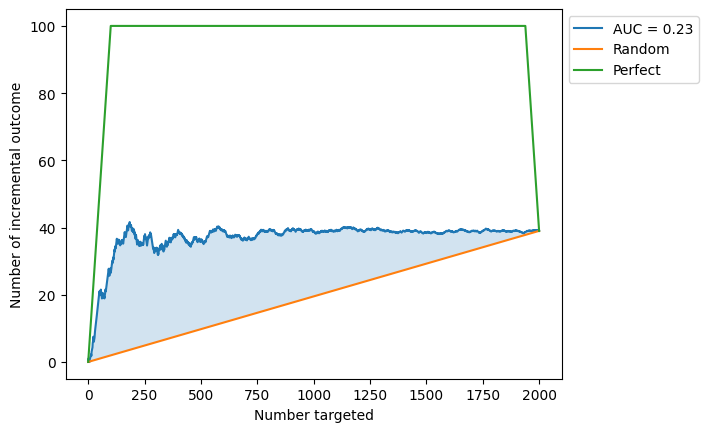

In [21]:
# Get the uplift metrics
from sklift.viz import plot_uplift_curve, plot_qini_curve, plot_uplift_by_percentile, plot_uplift_preds
from sklift.metrics import uplift_at_k, uplift_auc_score
plot_uplift_curve(y_true=df['converted'], uplift=df['uplift_score'], treatment=df['treatment'], perfect=True)
plot_qini_curve(y_true=df['converted'], uplift=df['uplift_score'], treatment=df['treatment'], perfect=True)

In [22]:
for k in [0.01, 0.05, 0.1, 0.25, 0.5]:
    val = uplift_at_k(y_true=df['converted'], uplift=df['uplift_score'], treatment=df['treatment'], strategy='overall', k=k)
    print(f"uplift at k {k}: {val}")
print(f"uplift auc: {uplift_auc_score(y_true=df['converted'], uplift=df['uplift_score'], treatment=df['treatment'])}")

uplift at k 0.01: 0.4285714285714286
uplift at k 0.05: 0.4651162790697675
uplift at k 0.1: 0.39
uplift at k 0.25: 0.140625
uplift at k 0.5: 0.07800000000000001
uplift auc: 0.06683621534015309


# Understand Uplift at K

In [25]:
import numpy as np
def my_uplift_at_k(y_true, uplift, treatment, strategy, k=0.3):
    """Compute uplift at first k observations by uplift of the total sample.

    Args:
        y_true (1d array-like): Correct (true) binary target values.
        uplift (1d array-like): Predicted uplift, as returned by a model.
        treatment (1d array-like): Treatment labels.
        k (float or int): If float, should be between 0.0 and 1.0 and represent the proportion of the dataset
            to include in the computation of uplift. If int, represents the absolute number of samples.
        strategy (string, ['overall', 'by_group']): Determines the calculating strategy.

            * ``'overall'``:
                The first step is taking the first k observations of all test data ordered by uplift prediction
                (overall both groups - control and treatment) and conversions in treatment and control groups
                calculated only on them. Then the difference between these conversions is calculated.

            * ``'by_group'``:
                Separately calculates conversions in top k observations in each group (control and treatment)
                sorted by uplift predictions. Then the difference between these conversions is calculated



    .. versionchanged:: 0.1.0

        * Add supporting absolute values for ``k`` parameter
        * Add parameter ``strategy``

    Returns:
        float: Uplift score at first k observations of the total sample.

    See also:
        :func:`.uplift_auc_score`: Compute normalized Area Under the Uplift curve from prediction scores.

        :func:`.qini_auc_score`: Compute normalized Area Under the Qini Curve from prediction scores.
    """

    # TODO: checker all groups is not empty
    
    
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    strategy_methods = ['overall', 'by_group']
    if strategy not in strategy_methods:
        raise ValueError(f'Uplift score supports only calculating methods in {strategy_methods},'
                         f' got {strategy}.'
                         )

    n_samples = len(y_true)
    order = np.argsort(uplift, kind='mergesort')[::-1]
    _, treatment_counts = np.unique(treatment, return_counts=True)
    n_samples_ctrl = treatment_counts[0]
    n_samples_trmnt = treatment_counts[1]

    k_type = np.asarray(k).dtype.kind

    if (k_type == 'i' and (k >= n_samples or k <= 0)
            or k_type == 'f' and (k <= 0 or k >= 1)):
        raise ValueError(f'k={k} should be either positive and smaller'
                         f' than the number of samples {n_samples} or a float in the '
                         f'(0, 1) range')

    if k_type not in ('i', 'f'):
        raise ValueError(f'Invalid value for k: {k_type}')

    if strategy == 'overall':
        if k_type == 'f':
            n_size = int(n_samples * k)
        else:
            n_size = k

        print(y_true[order][:n_size][treatment[order][:n_size] == 0].shape[0])
        print(y_true[order][:n_size][treatment[order][:n_size] == 0].sum())
        print(y_true[order][:n_size][treatment[order][:n_size] == 1].shape[0])
        print(y_true[order][:n_size][treatment[order][:n_size] == 1].sum())

        # ToDo: _checker_ there are observations among two groups among first k
        score_ctrl = y_true[order][:n_size][treatment[order][:n_size] == 0].mean()
        score_trmnt = y_true[order][:n_size][treatment[order][:n_size] == 1].mean()

    else:  # strategy == 'by_group':
        if k_type == 'f':
            n_ctrl = int((treatment == 0).sum() * k)
            n_trmnt = int((treatment == 1).sum() * k)

        else:
            n_ctrl = k
            n_trmnt = k

        if n_ctrl > n_samples_ctrl:
            raise ValueError(f'With k={k}, the number of the first k observations'
                             ' bigger than the number of samples'
                             f'in the control group: {n_samples_ctrl}'
                             )
        if n_trmnt > n_samples_trmnt:
            raise ValueError(f'With k={k}, the number of the first k observations'
                             ' bigger than the number of samples'
                             f'in the treatment group: {n_samples_ctrl}'
                             )
        print(y_true[order][treatment[order] == 0][:n_ctrl])
        print(y_true[order][treatment[order] == 1][:n_trmnt])
        score_ctrl = y_true[order][treatment[order] == 0][:n_ctrl].mean()
        score_trmnt = y_true[order][treatment[order] == 1][:n_trmnt].mean()

    return score_trmnt - score_ctrl

In [27]:
k = 0.01
val = my_uplift_at_k(y_true=df['converted'], uplift=df['uplift_score'], treatment=df['treatment'], strategy='overall', k=k)
print(f"uplift at k {k}: {val}")

10
2
10
10
uplift at k 0.01: 0.8


# Understanding how Qini plots are plotted

[   0  100 1939 2000] [  0. 100. 100.  39.]


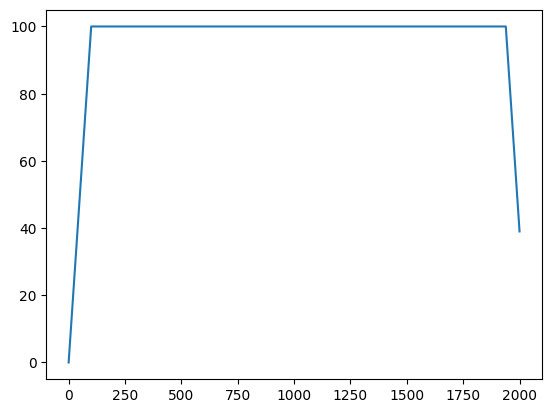

In [74]:
from sklearn.utils.extmath import stable_cumsum
import numpy as np

def my_qini_curve(y_true, uplift, treatment):
    """Compute Qini curve.

    For computing the area under the Qini Curve, see :func:`.qini_auc_score`.

    Args:
        y_true (1d array-like): Correct (true) target values.
        uplift (1d array-like): Predicted uplift, as returned by a model.
        treatment (1d array-like): Treatment labels.

    Returns:
        array (shape = [>2]), array (shape = [>2]): Points on a curve.

    See also:
        :func:`.uplift_curve`: Compute the area under the Qini curve.

        :func:`.perfect_qini_curve`: Compute the perfect Qini curve.

        :func:`.plot_qini_curves`: Plot Qini curves from predictions..

        :func:`.uplift_curve`: Compute Uplift curve.

    References:
        Nicholas J Radcliffe. (2007). Using control groups to target on predicted lift:
        Building and assessing uplift model. Direct Marketing Analytics Journal, (3):14–21, 2007.

        Devriendt, F., Guns, T., & Verbeke, W. (2020). Learning to rank for uplift modeling. ArXiv, abs/2002.05897.
    """

    
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    desc_score_indices = np.argsort(uplift, kind="mergesort")[::-1]

    y_true = y_true[desc_score_indices]
    treatment = treatment[desc_score_indices]
    uplift = uplift[desc_score_indices]

    y_true_ctrl, y_true_trmnt = y_true.copy(), y_true.copy()

    y_true_ctrl[treatment == 1] = 0
    y_true_trmnt[treatment == 0] = 0

    distinct_value_indices = np.where(np.diff(uplift))[0]
    threshold_indices = np.r_[distinct_value_indices, uplift.size - 1]

    num_trmnt = stable_cumsum(treatment)[threshold_indices]
    y_trmnt = stable_cumsum(y_true_trmnt)[threshold_indices]

    num_all = threshold_indices + 1

    num_ctrl = num_all - num_trmnt
    y_ctrl = stable_cumsum(y_true_ctrl)[threshold_indices]

    curve_values = y_trmnt - y_ctrl * np.divide(num_trmnt, num_ctrl, out=np.zeros_like(num_trmnt), where=num_ctrl != 0)
    if num_all.size == 0 or curve_values[0] != 0 or num_all[0] != 0:
        # Add an extra threshold position if necessary
        # to make sure that the curve starts at (0, 0)
        num_all = np.r_[0, num_all]
        curve_values = np.r_[0, curve_values]

    return num_all, curve_values


def my_perfect_qini_curve(y_true, treatment, negative_effect=True):
    """Compute the perfect (optimum) Qini curve.

    For computing the area under the Qini Curve, see :func:`.qini_auc_score`.

    Args:
        y_true (1d array-like): Correct (true) target values.
        treatment (1d array-like): Treatment labels.
        negative_effect (bool): If True, optimum Qini Curve contains the negative effects
            (negative uplift because of campaign). Otherwise, optimum Qini Curve will not
            contain the negative effects.
    Returns:
        array (shape = [>2]), array (shape = [>2]): Points on a curve.

    See also:
        :func:`.qini_curve`: Compute Qini curve.

        :func:`.qini_auc_score`: Compute the area under the Qini curve.

        :func:`.plot_qini_curves`: Plot Qini curves from predictions..
    """

    
    
    n_samples = len(y_true)

    y_true, treatment = np.array(y_true), np.array(treatment)

    if not isinstance(negative_effect, bool):
        raise TypeError(f'Negative_effects flag should be bool, got: {type(negative_effect)}')

    # express an ideal uplift curve through y_true and treatment
    if negative_effect:
        x_perfect, y_perfect = my_qini_curve(
            y_true, y_true * treatment - y_true * (1 - treatment), treatment
        )
    else:
        ratio_random = (y_true[treatment == 1].sum() - len(y_true[treatment == 1]) *
                        y_true[treatment == 0].sum() / len(y_true[treatment == 0]))

        x_perfect, y_perfect = np.array([0, ratio_random, n_samples]), np.array([0, ratio_random, ratio_random])

    return x_perfect, y_perfect

x, y = my_perfect_qini_curve(y_true=df['converted'],treatment=df['treatment'])
print(x, y)
plt.plot(x, y)

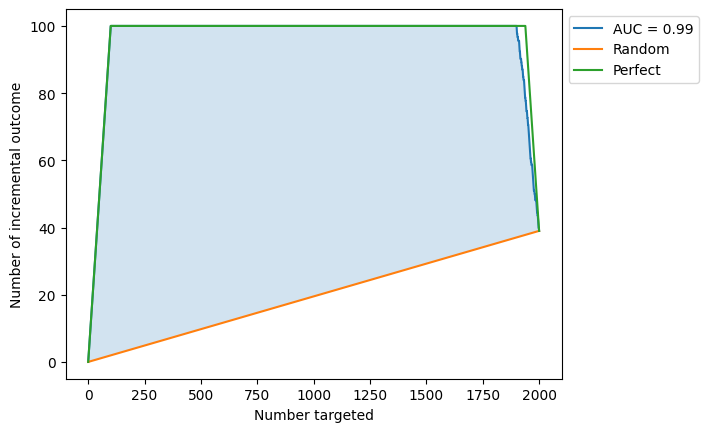

In [35]:
# Alternate the score assign function to get better model performance
noise = 0.1

uplift_score = list((treatment_df['user_number']) % converted_parameter)
uplift_score = [-1 * abs((random.random() - 0.5) * noise + x) for x in uplift_score]
treatment_df['uplift_score'] = uplift_score

# Control uplift score will also affect results
uplift_score = list((control_df['user_number']) % converted_parameter)
uplift_score = [1 * abs((random.random() - 0.5) * noise + x) - 1000 for x in uplift_score]
control_df['uplift_score'] = uplift_score

treatment_df['treatment'] = 1
control_df['treatment'] = 0
df = pd.concat([treatment_df, control_df])

# Get the uplift metrics
from sklift.viz import plot_uplift_curve, plot_qini_curve, plot_uplift_by_percentile, plot_uplift_preds
from sklift.metrics import uplift_at_k, uplift_auc_score
plot_qini_curve(y_true=df['converted'], uplift=df['uplift_score'], treatment=df['treatment'], perfect=True)

# Understanding how Uplift plots are plotted

[   0  100 1039 1939 2000] [   0.   100.  1039.   193.9   78. ]


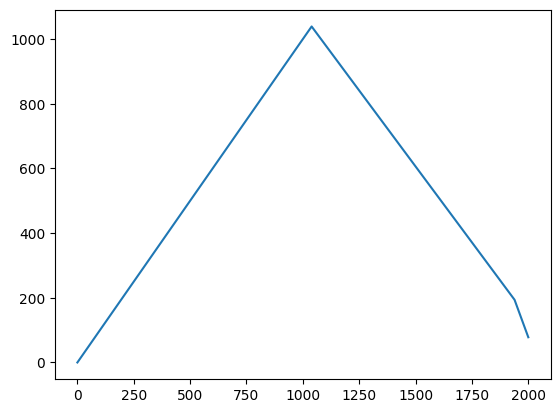

In [75]:
from sklearn.utils.extmath import stable_cumsum

def my_uplift_curve(y_true, uplift, treatment):
    """Compute Uplift curve.

    For computing the area under the Uplift Curve, see :func:`.uplift_auc_score`.

    Args:
        y_true (1d array-like): Correct (true) target values.
        uplift (1d array-like): Predicted uplift, as returned by a model.
        treatment (1d array-like): Treatment labels.

    Returns:
        array (shape = [>2]), array (shape = [>2]): Points on a curve.

    See also:
        :func:`.uplift_auc_score`: Compute normalized Area Under the Uplift curve from prediction scores.

        :func:`.perfect_uplift_curve`: Compute the perfect Uplift curve.

        :func:`.plot_uplift_curve`: Plot Uplift curves from predictions.

        :func:`.qini_curve`: Compute Qini curve.

    References:
        Devriendt, F., Guns, T., & Verbeke, W. (2020). Learning to rank for uplift modeling. ArXiv, abs/2002.05897.
    """

    
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    desc_score_indices = np.argsort(uplift, kind="mergesort")[::-1]
    y_true, uplift, treatment = y_true[desc_score_indices], uplift[desc_score_indices], treatment[desc_score_indices]

    y_true_ctrl, y_true_trmnt = y_true.copy(), y_true.copy()

    y_true_ctrl[treatment == 1] = 0
    y_true_trmnt[treatment == 0] = 0

    distinct_value_indices = np.where(np.diff(uplift))[0]
    threshold_indices = np.r_[distinct_value_indices, uplift.size - 1]
    

    num_trmnt = stable_cumsum(treatment)[threshold_indices]
    y_trmnt = stable_cumsum(y_true_trmnt)[threshold_indices]

    num_all = threshold_indices + 1

    num_ctrl = num_all - num_trmnt
    y_ctrl = stable_cumsum(y_true_ctrl)[threshold_indices]


    curve_values = (np.divide(y_trmnt, num_trmnt, out=np.zeros_like(y_trmnt), where=num_trmnt != 0) -
                    np.divide(y_ctrl, num_ctrl, out=np.zeros_like(y_ctrl), where=num_ctrl != 0)) * num_all

    if num_all.size == 0 or curve_values[0] != 0 or num_all[0] != 0:
        # Add an extra threshold position if necessary
        # to make sure that the curve starts at (0, 0)
        num_all = np.r_[0, num_all]
        curve_values = np.r_[0, curve_values]

    return num_all, curve_values


def my_perfect_uplift_curve(y_true, treatment):
    """Compute the perfect (optimum) Uplift curve.

    This is a function, given points on a curve.  For computing the
    area under the Uplift Curve, see :func:`.uplift_auc_score`.

    Args:
        y_true (1d array-like): Correct (true) target values.
        treatment (1d array-like): Treatment labels.

    Returns:
        array (shape = [>2]), array (shape = [>2]): Points on a curve.

    See also:
        :func:`.uplift_curve`: Compute the area under the Qini curve.

        :func:`.uplift_auc_score`: Compute normalized Area Under the Uplift curve from prediction scores.

        :func:`.plot_uplift_curve`: Plot Uplift curves from predictions.
    """

    
    
    y_true, treatment = np.array(y_true), np.array(treatment)

    cr_num = np.sum((y_true == 1) & (treatment == 0))  # Control Responders
    tn_num = np.sum((y_true == 0) & (treatment == 1))  # Treated Non-Responders

    # express an ideal uplift curve through y_true and treatment
    summand = y_true if cr_num > tn_num else treatment
    perfect_uplift = 2 * (y_true == treatment) + summand


    return my_uplift_curve(y_true, perfect_uplift, treatment)

x, y = my_perfect_uplift_curve(y_true=df['converted'],treatment=df['treatment'])
print(x, y)
plt.plot(x, y)